In [175]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import datetime as dt
sns.set(color_codes=True)
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot

load file as df

In [176]:
df=pd.read_csv("insurance.csv")

the first 5 rows, to get an inmpression of the data

In [177]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


what are the data types, and are there missing values?

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


no missing values, data types seem appropriate. How about duplicates?

In [179]:
t=df.duplicated()
df[t]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


Two persons share the exact same data. but with the number of variables(7) and the number of entries (1338) it is feasable that these are inded two different persons, instead of a duplicated entry. i keep the data.


let's see what values are in the "object" columns

In [180]:
df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [181]:
df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [182]:
df.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [183]:
df.describe(exclude="number")

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


now let's looks at the statistics of the numerical columns:

In [184]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


let's visualize the distribution of the numerical values

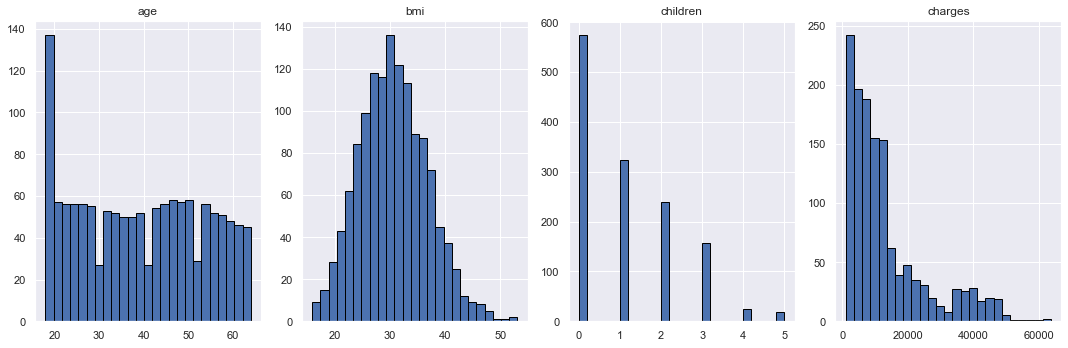

In [185]:
df.hist(bins=25, figsize=(15,5), layout=(-1, 4), edgecolor="black")
plt.tight_layout()

with the small number of numerical columns a pairplot is convenient to see patterns

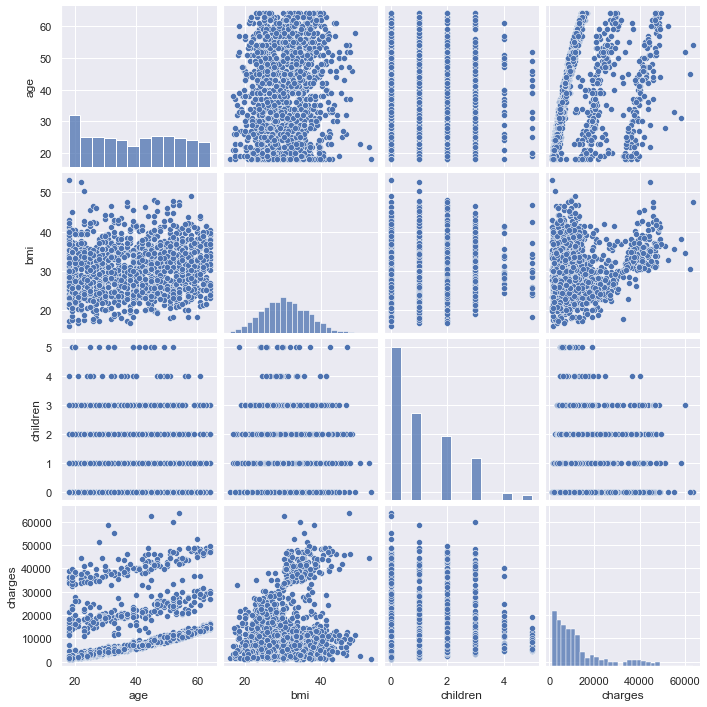

In [186]:
sns.pairplot(df)

the combinations charge-age and bmi-charge seem to have an interesting distribution, so let's have a closer look



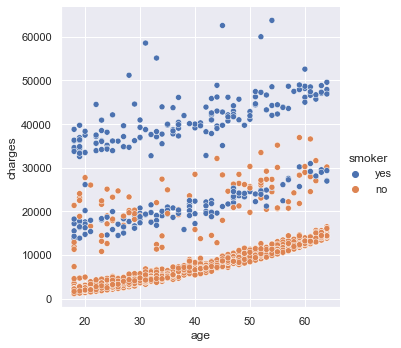

In [187]:
sns.relplot(data=df,x="age",y="charges",hue="smoker")

charges go up with age, and being a smoker clearly increases the charges, but there seems to be yet another factor

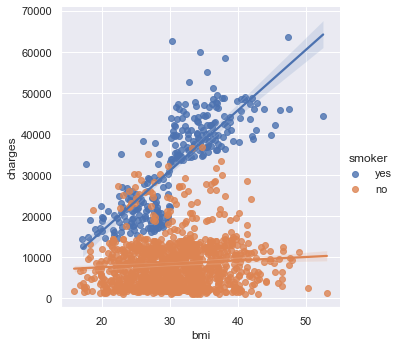

In [188]:
sns.lmplot(data=df,x="bmi",y="charges",hue="smoker")

bmi seems to affect strongly for smokers, less so for non-smokers.
Furthermore, there seem to be two clusters within the smokers: below and above bmi 30. so let's create a binary column "high bmi" with that cut-off

In [189]:
df["high_bmi"]=df.bmi.apply(lambda x: "yes" if x>=30 else "no")


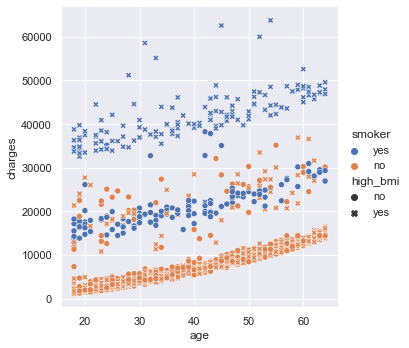

In [190]:
sns.relplot(data=df,x="age",y="charges",hue="smoker",style="high_bmi")

The division into high and low bmi explains the two clusters in the smoker group.
it is obvious that for all ages the highest charges are payed by smokers with a high bmi

<AxesSubplot:xlabel='region', ylabel='charges'>

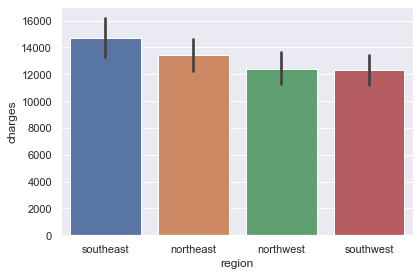

In [191]:
o=df.groupby("region").charges.mean().sort_values(ascending=False).index
sns.barplot(data=df, x="region", y="charges",order=o)

charges are highest in southeast and lowest in southwest, but there are also many smokers

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:xlabel='region', ylabel='count'>

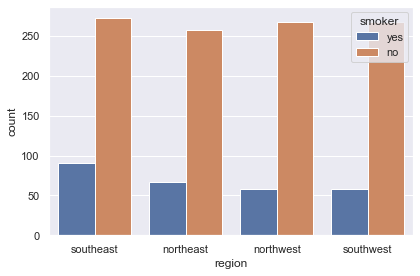

In [192]:
plt.figure()
plt.legend()
sns.countplot(x='region', data=df,hue="smoker",order=o)

Below we can see the average charges, grouped by region, gender and smoker status. lowest charges are payed by nonsmoking men in the southeast, highest by smoking men also in southeast. We can see that there is a clear division between smokers and non-smokers.

In [193]:
df.groupby(["region","sex","smoker"]).charges.mean().sort_values()

region     sex     smoker
southeast  male    no         7609.003587
southwest  male    no         7778.905534
           female  no         8234.091260
northwest  male    no         8320.689321
southeast  female  no         8440.205552
northeast  male    no         8664.042222
northwest  female  no         8786.998679
northeast  female  no         9640.426984
                   yes       28032.046398
northwest  female  yes       29670.824946
           male    yes       30713.181419
northeast  male    yes       30926.252583
southwest  female  yes       31687.988430
           male    yes       32598.862854
southeast  female  yes       33034.820716
           male    yes       36029.839367
Name: charges, dtype: float64

Now I attempt to make a predictive model for "charges" using statsmodel. First I just use "smoker" as the most compound factor as predictive value: it already explains 62% of the outcome "charges"

In [194]:
fit=smf.ols("charges ~ smoker", data=df).fit()
print(fit.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2178.
Date:                Sat, 30 Jul 2022   Prob (F-statistic):          8.27e-283
Time:                        22:30:09   Log-Likelihood:                -13831.
No. Observations:                1338   AIC:                         2.767e+04
Df Residuals:                    1336   BIC:                         2.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8434.2683    229.014     36.829

now I add in all the other factors I use the rescaled normalized values from then numeric columns to ease interpretation.


In [195]:
#this function centers and normalizes numeric data. it takes a series as a parameter and returns the rescaled series
def rescale(series):
    sigma=2*(series.std())
    mean=series.mean()

    
    return (series-mean)/(sigma)

Rescale all numeric columns in dataframe. the original columns remain, the rescaled and normalized columns are named "s+ {original column name}"

In [196]:
columns=df.columns
for c in columns:
    if df[c].dtype=="int64" or df[c].dtype=="float64" :
        name="s"+c
        df[name]=rescale(df[c])
df.describe()

,age,bmi,children,charges,sage,sbmi,schildren,scharges
count,1338.000000,1338.000000,1338.000000,1338.000000,1.338000e+03,1.338000e+03,1.338000e+03,1.338000e+03
mean,39.207025,30.663397,1.094918,13270.422265,-8.364012e-17,-1.062097e-16,-3.650958e-17,-3.850101e-17
std,14.049960,6.098187,1.205493,12110.011237,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
min,18.000000,15.960000,0.000000,1121.873900,-7.547005e-01,-1.205555e+00,-4.541370e-01,-5.015911e-01
25%,27.000000,26.296250,0.000000,4740.287150,-4.344149e-01,-3.580693e-01,-4.541370e-01,-3.521935e-01
50%,39.000000,30.400000,1.000000,9382.033000,-7.367473e-03,-2.159633e-02,-3.936888e-02,-1.605444e-01
75%,51.000000,34.693750,2.000000,16639.912515,4.196800e-01,3.304550e-01,3.753993e-01,1.391200e-01
max,64.000000,53.130000,5.000000,63770.428010,8.823148e-01,1.842072e+00,1.619704e+00,2.085052e+00


In [197]:
df.head()

,age,sex,bmi,children,smoker,region,charges,high_bmi,sage,sbmi,schildren,scharges
0,19,female,27.900,0,yes,southwest,16884.92400,no,-0.719113,-0.226575,-0.454137,0.149236
1,18,male,33.770,1,no,southeast,1725.55230,yes,-0.754701,0.254715,-0.039369,-0.476666
2,28,male,33.000,3,no,southeast,4449.46200,yes,-0.398828,0.191582,0.790167,-0.364201
3,33,male,22.705,0,no,northwest,21984.47061,no,-0.220891,-0.652522,-0.454137,0.359787
4,32,male,28.880,0,no,northwest,3866.85520,no,-0.256478,-0.146224,-0.454137,-0.388256


In [198]:
fit=smf.ols("charges ~ smoker + sex + sbmi + sage + region + schildren ", data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Sat, 30 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:30:09   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            9053.4925    

The model got much better.
I now also add the interactions of some predictive variables. We saw before that region in combination with smoker might have an effect. charges also correlated differently with bmi depending on smoking status.


In [199]:
fit=smf.ols("charges ~ smoker + sex + sbmi + sage + region + schildren + smoker:region + smoker:sbmi", data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     585.6
Date:                Sat, 30 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:30:09   Log-Likelihood:                -13246.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1325   BIC:                         2.659e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

let's see how interaction with age affects the model

In [200]:
fit=smf.ols("charges ~ smoker + sex + sbmi + sage + region + schildren + smoker:region + smoker:sbmi + smoker:sage + sage:sbmi + sage:region", data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     413.6
Date:                Sat, 30 Jul 2022   Prob (F-statistic):               0.00
Time:                        22:30:09   Log-Likelihood:                -13243.
No. Observations:                1338   AIC:                         2.652e+04
Df Residuals:                    1320   BIC:                         2.662e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

while age is an important predictor (2nd highest coefficient), it doesn't seem to interact with other factors
Overall, this model explains 84% of the charges. Being a smoker is the most expensive factor, followed by age, children and bmi.

In [201]:
smo=df[df.smoker=="yes"]
co=smo.loc[:,["age","children","charges","bmi"]].corr()
nosmo=df[df.smoker=="no"]
nco=nosmo.loc[:,["age","children","charges","bmi"]].corr()

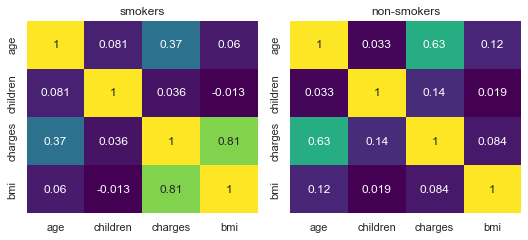

In [202]:

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(co, cmap="viridis",annot=True, ax=ax1, cbar=False).set_title("smokers")
sns.heatmap(nco, cmap="viridis",annot=True, ax=ax2, cbar=False).set_title("non-smokers")
fig.subplots_adjust(wspace=0.001)




for smokers the charges positively correlate with bmi and still but less with age. for non-smokers, charges positively correlate most with age, but not with bmi. This is quite obviouse from the plot below:


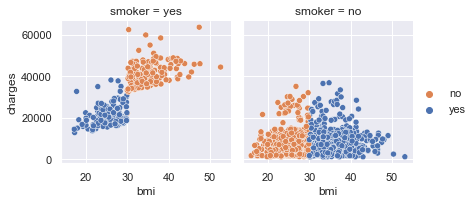

In [203]:
g = sns.FacetGrid(df, col="smoker")

g.map_dataframe(sns.scatterplot, x="bmi", y="charges", hue="high_bmi")
g.add_legend()

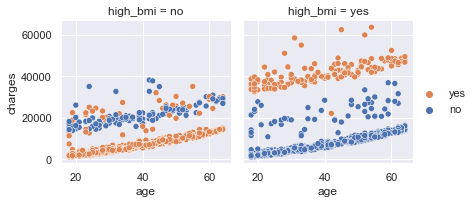

In [204]:
g = sns.FacetGrid(df, col="high_bmi")

g.map_dataframe(sns.scatterplot, x="age", y="charges", hue="smoker")
g.add_legend()